In [0]:
from keras.layers import Input
from keras.models import Model
from keras.utils.vis_utils import plot_model
import os
import numpy as np
import skimage.io
import glob
import keras
from keras.datasets import cifar10
from keras.layers import Activation
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, \
    GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras import preprocessing
import matplotlib.pyplot as plt
from keras.layers.core import Lambda
import tensorflow as tf
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
drive.mount('/content/gdrive')

# save the losses figure and create a new figure for the accuracies

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
EPOCHS = 60
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (48, 48, 3)


In [0]:
data_x = []
data_y_e = []
data_y_f = []

directory = glob.glob("/content/gdrive/Team Drives/Deep Learning/Datasets/Webcam_team_dataset/*")

for folder in directory:
    files = os.listdir(folder)
    files.sort()
    for filename in files:
        if filename == '.DS_Store':
            continue
        I = skimage.io.imread(os.path.join(folder, filename))
        data_x.append(I.tolist())
        label1 = folder.split("/")
        label2 = filename.split('_')
        data_y_f.append([label2[0]])
        data_y_e.append([label1[7]])
    print('Completed')

print(np.shape(data_x))

mlb1 = LabelBinarizer()
mlb2 = LabelBinarizer()
label1 = mlb1.fit_transform(np.array(data_y_f))
label2 = mlb2.fit_transform(np.array(data_y_e))

print(mlb1.classes_)

Completed
Completed
Completed
Completed
Completed
(5086, 48, 48, 3)
['Akarsh' 'Anthony' 'Naren' 'akanksha' 'harsh']


In [0]:
mlb1 = LabelBinarizer()
mlb2 = LabelBinarizer()
label1 = mlb1.fit_transform(np.array(data_y_f))
label2 = mlb2.fit_transform(np.array(data_y_e))

print(mlb1.classes_)

['Akarsh' 'Anthony' 'Naren' 'akanksha' 'harsh']


In [0]:

image_generator = ImageDataGenerator(
               featurewise_center=False,
               samplewise_center=False,
               featurewise_std_normalization=False,
               samplewise_std_normalization=False,
               zca_whitening=True,
               rotation_range=20,
               width_shift_range=0.1,
               height_shift_range=0.1,
               horizontal_flip=True,
               vertical_flip=False)

data_x = np.array(data_x)
randidx = np.random.randint(data_x.shape[0], size=5000)
image_generator.fit(data_x,augment=True)
x_augmented = data_x[randidx].copy()
label1_augmented = label1[randidx].copy()
label2_augmented = label2[randidx].copy()
x_augmented = image_generator.flow(x_augmented,np.zeros(5000),batch_size=5000, shuffle=False).next()[0]
data_x = np.concatenate((data_x, x_augmented))
label1 = np.concatenate((label1, label1_augmented))
label2 = np.concatenate((label2, label2_augmented))


split = train_test_split(data_x, label1, label2, test_size=0.05, random_state=49)
(x_train, x_test, trainfaceY, testfaceY,trainexpY, testexpY) = split



# Normalize data set to 0-to-1 range
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
x_train /= 255
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 3)

x_test = x_test.reshape(x_test.shape[0], 48, 48, 3)

print(np.shape(x_test))


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:334: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


(505, 48, 48, 3)


In [0]:
class FaceEmoNet:
    @staticmethod
    def build_layer(inputs, numFaces,numExp, finalAct="softmax"):
        x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', name='Conv2D_1',
                   input_shape=(48, 48, 3))(inputs)
        x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name='Conv2D_2')(x)
        x = AveragePooling2D(pool_size=(3, 3), padding='same', name='AveragePooling2D_1')(x)        
        x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='Conv2D_3')(x)
        x = AveragePooling2D(pool_size=(3, 3), padding='same', name= 'AveragePooling2D_2')(x)
        x = Flatten(name='Flatten_1')(x)
        x = Dense(units=1600, activation='relu',name='FC_1')(x)
        x = Dropout(0.2,name='Dropout_1')(x)
        y = Dense(units=800, activation='relu',name='FC_2a')(x)
        y = Dropout(0.2, name='Dropout_2a')(y)
        z = Dense(units=800, activation='relu',name='FC_2b')(x)
        z = Dropout(0.2, name='Droptout_2b')(z)
        
        y = Dense(units=5, activation="softmax", name='face_predict')(y)

        z = Dense(units=5, activation="softmax", name='exp_predict')(z)
        return [y, z]

    @staticmethod
    def build(width, height, numFaces, numExp, finalAct="softmax"):

        inputShape = (height, width, 3)
        inputs = Input(shape=inputShape, name='Input')
        share = FaceEmoNet.build_layer(inputs, numFaces,numExp,finalAct=finalAct)


        model = Model(
            inputs=inputs,
            outputs=share,
            name="tester")

       
        return model


model = FaceEmoNet.build(48, 48,
                         numFaces=len(label1[0]),
                         numExp=len(label2[0]),
                         finalAct="softmax")

losses = {
    "face_predict": "categorical_crossentropy",
    "exp_predict": "categorical_crossentropy",
}

lossWeights = {"face_predict": 1.0, "exp_predict": 1.0}

# initialize the optimizer and compile the model
print("[INFO] compiling model...")


opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
              metrics=["accuracy"])




[INFO] compiling model...


In [0]:

H = model.fit(x_train,
              {"face_predict": trainfaceY, "exp_predict": trainexpY},
              validation_data=(x_test,
                               {"face_predict": testfaceY, "exp_predict": testexpY}),
              epochs=EPOCHS,
              verbose=1, shuffle=True)




Train on 9581 samples, validate on 505 samples
Epoch 1/60
9581/9581 [==============================] - 5s 484us/step - loss: 2.1581 - face_predict_loss: 0.9334 - exp_predict_loss: 1.2247 - face_predict_acc: 0.5502 - exp_predict_acc: 0.4360 - val_loss: 1.7084 - val_face_predict_loss: 0.7478 - val_exp_predict_loss: 0.9606 - val_face_predict_acc: 0.6475 - val_exp_predict_acc: 0.5723
Epoch 2/60
9581/9581 [==============================] - 4s 390us/step - loss: 1.4166 - face_predict_loss: 0.6418 - exp_predict_loss: 0.7749 - face_predict_acc: 0.7284 - exp_predict_acc: 0.6777 - val_loss: 1.0848 - val_face_predict_loss: 0.3968 - val_exp_predict_loss: 0.6880 - val_face_predict_acc: 0.8475 - val_exp_predict_acc: 0.7248
Epoch 3/60
9581/9581 [==============================] - 4s 402us/step - loss: 0.8465 - face_predict_loss: 0.2642 - exp_predict_loss: 0.5823 - face_predict_acc: 0.9015 - exp_predict_acc: 0.7650 - val_loss: 0.6614 - val_face_predict_loss: 0.1792 - val_exp_predict_loss: 0.4821 - val_

Saved model to disk


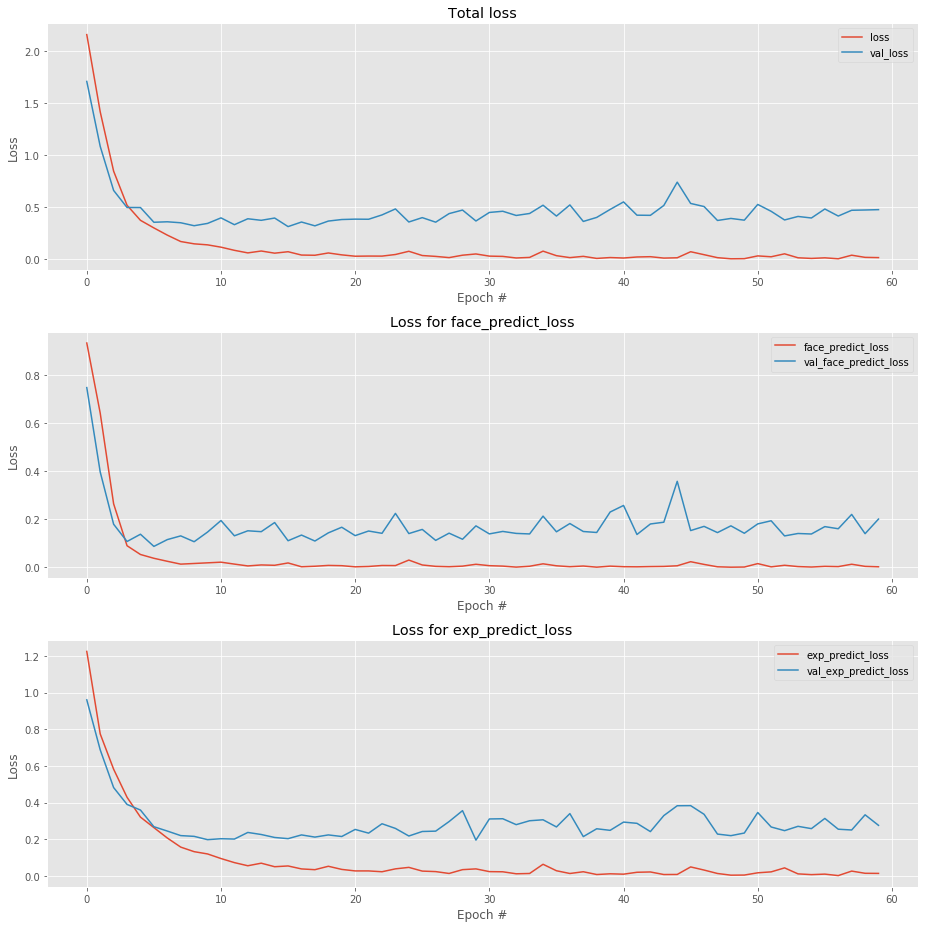

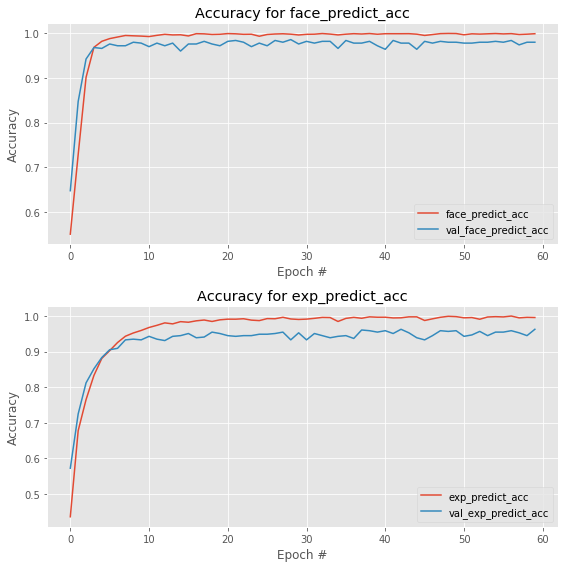

In [0]:
model_json = model.to_json()
with open("/content/gdrive/Team Drives/Deep Learning/Models/newmodel.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("/content/gdrive/Team Drives/Deep Learning/Models/newmodel.h5")
print("Saved model to disk")

lossNames = ["loss", "face_predict_loss", "exp_predict_loss"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(np.arange(0, EPOCHS), H.history[l], label=l)
    ax[i].plot(np.arange(0, EPOCHS), H.history["val_" + l],
               label="val_" + l)
    ax[i].legend()
plt.tight_layout()

accuracyNames = ["face_predict_acc", "exp_predict_acc"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(2, 1, figsize=(8, 8))

# loop over the accuracy names
for (i, l) in enumerate(accuracyNames):
    # plot the loss for both the training and validation data
    ax[i].set_title("Accuracy for {}".format(l))
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Accuracy")
    ax[i].plot(np.arange(0, EPOCHS), H.history[l], label=l)
    ax[i].plot(np.arange(0, EPOCHS), H.history["val_" + l],
               label="val_" + l)
    ax[i].legend()

# save the accuracies figure
plt.tight_layout()

In [0]:
# Read Test data and build labels


test_data_x = []
test_data_y_e = []
test_data_y_f = []

directory = glob.glob("/content/gdrive/Team Drives/Deep Learning/Datasets/MCB/*")

for folder in directory:
    files = os.listdir(folder)
    files.sort()
    for filename in files:
        if filename == '.DS_Store':
            continue
        I = skimage.io.imread(os.path.join(folder, filename))
        test_data_x.append(I.tolist())
        label_1 = folder.split("/")
        label_2 = filename.split('_')
        test_data_y_f.append([label_2[0]])
        test_data_y_e.append([label_1[7]])
    print('Completed')


mlb_3 = LabelBinarizer()
mlb_4 = LabelBinarizer()
label_test1 = mlb_3.fit_transform(np.array(test_data_y_f))
label_test2 = mlb_4.fit_transform(np.array(test_data_y_e))



Completed
Completed
Completed
Completed
Completed


In [0]:
print(np.shape(test_data_x))
print(np.shape(label_test2))

test_data_x = np.array(test_data_x, dtype=np.float32)
test_data_x /= 255
test_data_x = test_data_x.reshape(test_data_x.shape[0], 48, 48, 3)

(2487, 48, 48, 3)
(2487, 5)


In [0]:
json_file = open('newmodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("newmodel.h5")
print("Loaded model from disk")

In [0]:
X = loaded_model.evaluate(test_data_x,{"face_predict": label_test1, "exp_predict": label_test2},batch_size=32,verbose=1)

2487/2487 [==============================] - 0s 128us/step


In [0]:
print(model.metrics_names)
print(X)


['loss', 'face_predict_loss', 'exp_predict_loss', 'face_predict_acc', 'exp_predict_acc']
[1.1461890307494733, 0.3271896951213039, 0.818999347191136, 0.9412947327054357, 0.8926417370325693]


In [0]:
lab_face=[]
lab_exp=[]


for i in test_data_x:
  face_tem,exp_tem = loaded_model.predict(i.reshape(1,48,48,3))
  lab_face.append(face_tem)
  lab_exp.append(exp_tem)

In [0]:
print(np.shape(lab_face))
print(np.shape(lab_exp))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras import metrics

lab_face= np.round(lab_face)
lab_face=lab_face.astype(int)
lab_face = lab_face.reshape(lab_face.shape[0],5)
print(np.shape(lab_face))
print(np.shape(label_test1))
person_list = mlb1.classes_
print(person_list)
print(confusion_matrix(label_test1.argmax(axis=1), lab_face.argmax(axis=1)))
print(classification_report(label_test1.argmax(axis=1),lab_face.argmax(axis=1),target_names=person_list))

lab_exp=np.round(lab_exp)
lab_exp=lab_exp.astype(int)
lab_exp= lab_exp.reshape(lab_exp.shape[0],5)
print(confusion_matrix(label_test2.argmax(axis=1), lab_exp.argmax(axis=1)))
print(classification_report(label_test2.argmax(axis=1),lab_exp.argmax(axis=1),target_names=mlb2.classes_))


(2487, 5)
(2487, 5)
(2487, 5)
(2487, 5)
['Akarsh' 'Anthony' 'Naren' 'akanksha' 'harsh']
[[499   0   1   0   0]
 [  7 373 104   0  16]
 [  0   0 486   0  11]
 [  0   0   0 489   0]
 [  1   2   5   0 493]]
              precision    recall  f1-score   support

      Akarsh       0.98      1.00      0.99       500
     Anthony       0.99      0.75      0.85       500
       Naren       0.82      0.98      0.89       497
    akanksha       1.00      1.00      1.00       489
       harsh       0.95      0.98      0.97       501

   micro avg       0.94      0.94      0.94      2487
   macro avg       0.95      0.94      0.94      2487
weighted avg       0.95      0.94      0.94      2487

[[395  79  20   6   0]
 [  0 500   1   0   0]
 [  3  82 415   0   0]
 [ 28   4  14 442   1]
 [  1  18   4   0 474]]
              precision    recall  f1-score   support

       Angry       0.93      0.79      0.85       500
       Happy       0.73      1.00      0.84       501
     Neutral       0.91     